<a href="https://colab.research.google.com/github/ryansilvatrb/Transfer_learning_fine-tuning/blob/main/notebooks/C%C3%B3pia_de_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.


In [ ]:
# =====================================================
# 1️⃣ Importar bibliotecas
# =====================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

print("TensorFlow versão:", tf.__version__)

TensorFlow versão: 2.19.0


### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000.

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

In [ ]:
# =====================================================
# 2️⃣ Baixar e extrair o dataset manualmente
# =====================================================
!echo "Baixando dataset Cats vs Dogs..."
!curl -L -o /content/cats_and_dogs_filtered.zip \
"https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

!echo "Extraindo dataset..."
!unzip -q /content/cats_and_dogs_filtered.zip -d /content

base_dir = "/content/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

print("Base dir:", base_dir)
print("Train dir existe?", os.path.exists(train_dir))
print("Validation dir existe?", os.path.exists(validation_dir))
print("Subpastas treino:", os.listdir(train_dir))
print("Subpastas validação:", os.listdir(validation_dir))


Baixando dataset Cats vs Dogs...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  14.7M      0  0:00:04  0:00:04 --:--:-- 15.8M
Extraindo dataset...
Base dir: /content/cats_and_dogs_filtered
Train dir existe? True
Validation dir existe? True
Subpastas treino: ['dogs', 'cats']
Subpastas validação: ['dogs', 'cats']


In [ ]:
# =====================================================
# 3️⃣ Pré-processamento das imagens
# =====================================================
img_size = (160, 160)
batch_size = 32

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

val_dataset = keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

# Normalização
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


This function is useful for pre-processing the data into an image and input vector.

In [ ]:
# =====================================================
# 4️⃣ Carregar modelo pré-treinado (MobileNetV2)
# =====================================================
IMG_SHAPE = img_size + (3,)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False  # congelar camadas

global_avg_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation="sigmoid")

model = models.Sequential([
    base_model,
    global_avg_layer,
    prediction_layer
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Load all the images from root folder

In [ ]:
# =====================================================
# 5️⃣ Treinamento inicial
# =====================================================
epochs = 5
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 553ms/step - accuracy: 0.5182 - loss: 0.9303 - val_accuracy: 0.6870 - val_loss: 0.5998
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7569 - loss: 0.5350 - val_accuracy: 0.8370 - val_loss: 0.4197
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8648 - loss: 0.3753 - val_accuracy: 0.8900 - val_loss: 0.3214
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8976 - loss: 0.2978 - val_accuracy: 0.9190 - val_loss: 0.2625
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9265 - loss: 0.2353 - val_accuracy: 0.9320 - val_loss: 0.2242


Randomize the data order.

In [ ]:
# =====================================================
# 6️⃣ Fine-tuning (opcional)
# =====================================================
# Descongelar algumas camadas do base_model
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs_fine = 5
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs_fine
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 364ms/step - accuracy: 0.8283 - loss: 0.3783 - val_accuracy: 0.9600 - val_loss: 0.1237
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9330 - loss: 0.2048 - val_accuracy: 0.9640 - val_loss: 0.0957
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9563 - loss: 0.1423 - val_accuracy: 0.9700 - val_loss: 0.0819
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9792 - loss: 0.0957 - val_accuracy: 0.9730 - val_loss: 0.0740
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9801 - loss: 0.0763 - val_accuracy: 0.9750 - val_loss: 0.0685


create training / validation / test split (70%, 15%, 15%)

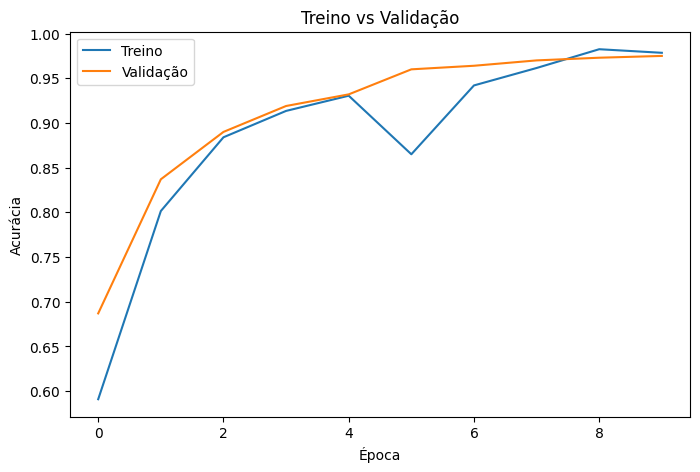

In [ ]:
# =====================================================
# 7️⃣ Plotar acurácia
# =====================================================
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8,5))
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.title("Treino vs Validação")
plt.show()

Separate data for labels.

In [ ]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf

def predict_images_grid(folder_path, max_images=20):
    """
    Mostra várias imagens de uma pasta com as predições do modelo.
    - folder_path: pasta com subpastas de classes (cats, dogs)
    - max_images: número máximo de imagens a exibir
    """
    images = []
    labels = []

    # Percorrer as subpastas (cats, dogs)
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            for img_file in os.listdir(cls_path):
                images.append(os.path.join(cls_path, img_file))
                labels.append(cls)
                if len(images) >= max_images:
                    break
        if len(images) >= max_images:
            break

    n = len(images)
    cols = 5
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 3*rows))

    for i, img_path in enumerate(images):
        # Carregar imagem
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array_exp = tf.expand_dims(img_array, 0) / 255.0

        # Predição
        prediction = model.predict(img_array_exp, verbose=0)[0][0]
        pred_label = "Gato 🐱" if prediction < 0.5 else "Cachorro 🐶"
        prob = prediction if prediction >= 0.5 else 1 - prediction

        # Plotar
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_array.astype("uint8"))
        plt.axis('off')
        plt.title(f"{pred_label}\n({prob*100:.1f}%)")

    plt.tight_layout()
    plt.show()

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

/tmp/ipython-input-1436031092.py:50: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


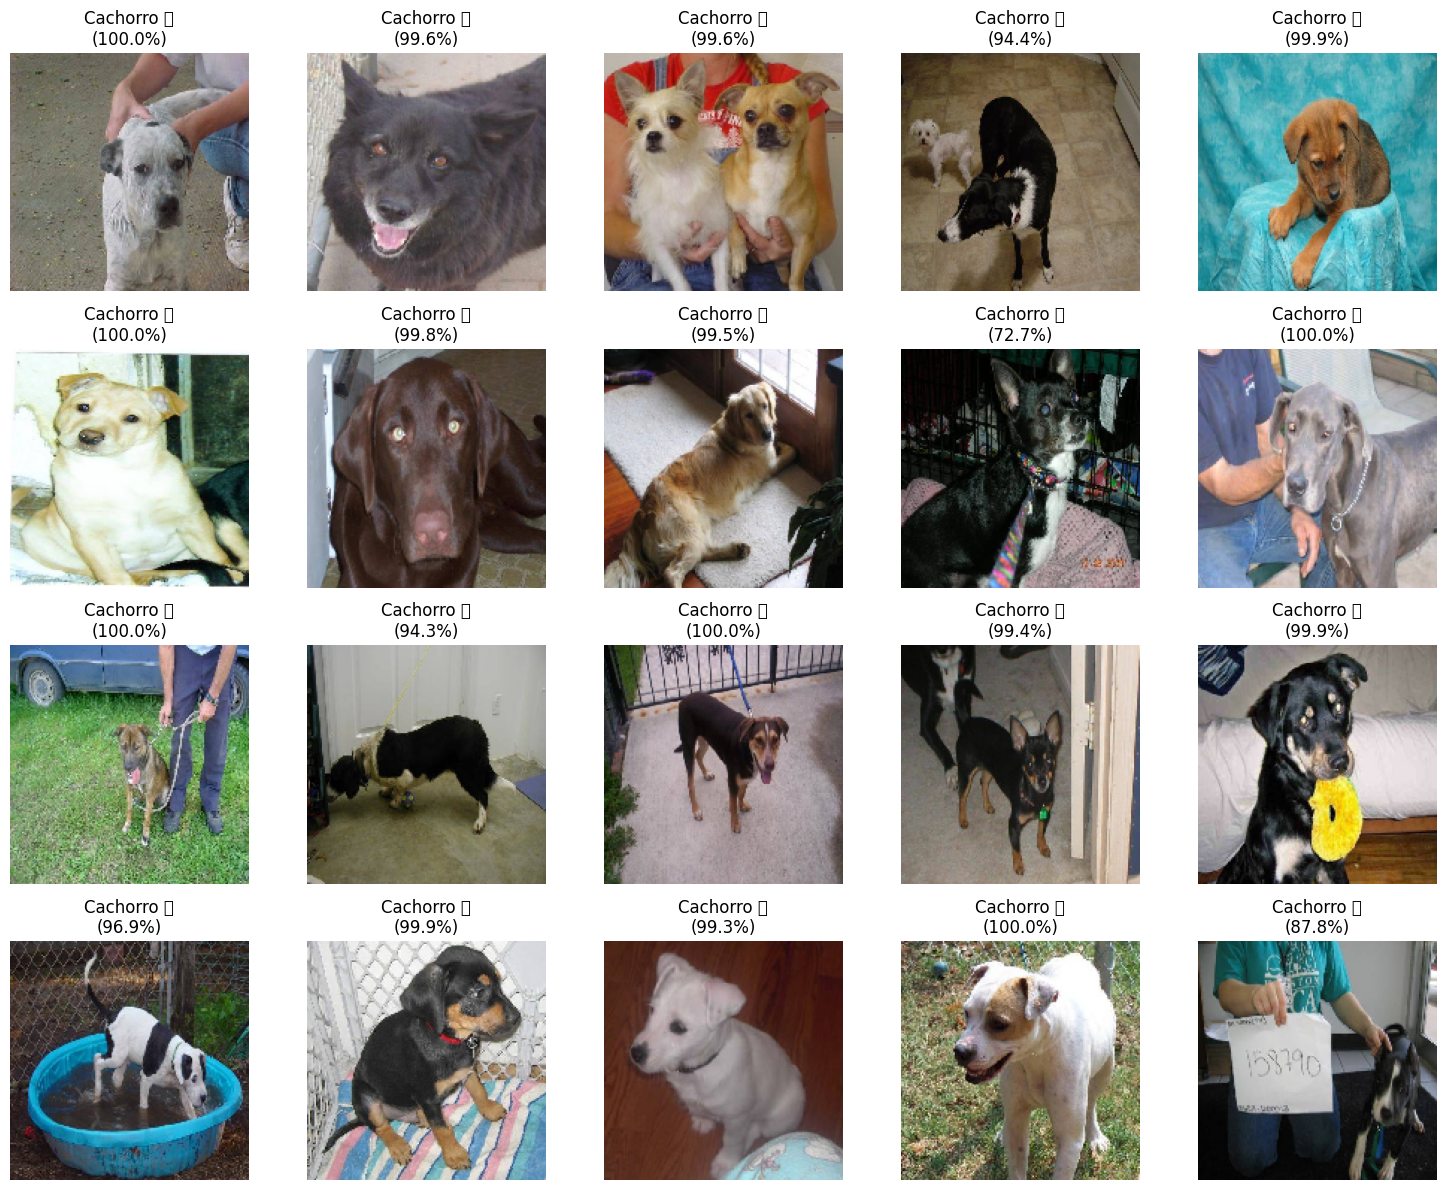

In [ ]:
validation_path = "/content/cats_and_dogs_filtered/validation"
predict_images_grid(validation_path, max_images=20)

In [ ]:
cat_test = "/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg"
dog_test = "/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg"

# Conferir se os arquivos existem
import os
print("Gato existe?", os.path.exists(cat_test))
print("Cachorro existe?", os.path.exists(dog_test))

Gato existe? True
Cachorro existe? True


Let's get a summary of what we have.

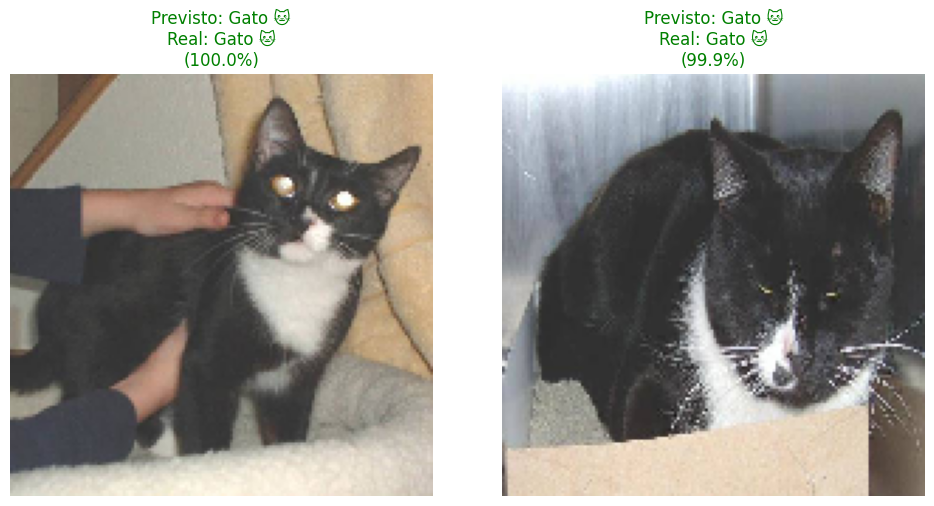

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf

# Defina o tamanho usado no treino
img_size = (150, 150)

def predict_and_plot_grid_colored(img_paths, true_labels):
    """
    img_paths: lista com caminhos das imagens
    true_labels: lista com labels reais ("Gato 🐱" ou "Cachorro 🐶")
    """
    n = len(img_paths)
    cols = n
    plt.figure(figsize=(5*cols, 5))

    for i, img_path in enumerate(img_paths):
        # Carregar imagem
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array_exp = tf.expand_dims(img_array, 0) / 255.0

        # Predição
        prediction = model.predict(img_array_exp, verbose=0)[0][0]
        pred_label = "Gato 🐱" if prediction < 0.5 else "Cachorro 🐶"
        prob = prediction if prediction >= 0.5 else 1 - prediction

        # Checar se predição está correta
        is_correct = pred_label == true_labels[i]
        color = "green" if is_correct else "red"

        # Plotar
        plt.subplot(1, cols, i+1)
        plt.imshow(img_array.astype("uint8"))
        plt.axis('off')
        plt.title(f"Previsto: {pred_label}\nReal: {true_labels[i]}\n({prob*100:.1f}%)",
                  color=color, fontsize=12)

    plt.tight_layout()
    plt.show()


# Exemplo de uso: apenas gatos
cat_test1 = "/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg"
cat_test2 = "/content/cats_and_dogs_filtered/validation/cats/cat.2001.jpg"

# Lista de imagens (só gatos nesse caso)
img_paths = [cat_test1, cat_test2]
true_labels = ["Gato 🐱", "Gato 🐱"]

# Chamada da função
predict_and_plot_grid_colored(img_paths, true_labels)

If everything worked properly, you should have loaded a bunch of images, and split them into three sets: `train`, `val`, and `test`. The shape of the training data should be (`n`, 224, 224, 3) where `n` is the size of your training set, and the labels should be (`n`, `c`) where `c` is the number of classes (97 in the case of `101_ObjectCategories`.

Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.